# Homework 3 - data transformation & dimensionality reduction (deadline 26. 12. 2020, 23:59)

In short, the main task is to play with transformations and dimensionality reduction to obtain the best results for the linear regression model predicting house sale prices.
  
> The instructions are not given in detail: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can!

## What are you supposed to do:

Your aim is to optimize the _RMSLE_ (see the note below) of the linear regression estimator (=our prediction model) of the observed sale prices.

### Instructions:

  1. Download the dataset from the course pages (data.csv, data_description.txt). It corresponds to [this Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). 
  1. Transform features appropriately and prepare new ones - focus on the increase in the performance of the model (possibly in combination with further steps). Split the dataset into a train and test part exactly as we did in the tutorials. Use the test part for evaluation of the influence of further steps.
  1. Try to find some suitable subset of features - first without the use of PCA.
  1. Use PCA (principal component analysis) to reduce the dimensionality. Discuss the influence of the number of principal components.
  1. Compare the results of previous steps on the test part of the dataset.
  
Give comments (!) on each step of your solution, with short explanations of your choices.

**If you do all this properly, you will obtain 16 points.** 


**Note**: _RMSLE_ is a Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sale prices.


## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, she can (!) give you another chance to rework your homework and to obtain more points. However, this is not a given, so do your best! :)
  * English is not compulsory.

# here comes my code

- **TOC TBD**

## Train test split disclaimer

- TBD



### Libraries Imports

In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
# from pandas.api.types import CategoricalDtype

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler



In [2]:
SEED = 42

### Data exploration funcitons

In [3]:
def unique_data_types(df):
    return df.dtypes.unique()
    
def columns_by_type(df, dtype):
    return df.columns[df.dtypes == dtype].values

def showBarplotWithPercentages(x, y, df, total=None, title=f""):
    """Show barplot with bars in descending order and percentages on top"""

    df = df.sort_values(by=y, ascending=False)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.barplot(x=x, y=y, data=df, ax=ax, palette="muted")

    for p in ax.patches:
        if total is not None:
            annotation = '{:.1f}%'.format((p.get_height()/total) * 100) # percentage
        else:
            annotation = p.get_height()
        x = p.get_x() + p.get_width()/10
        y = int((p.get_y() + p.get_height()*1.005))
        ax.annotate(annotation, (x, y))

    ax.set_title(title)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
    return ax

def show_missing_values(df, x="feature", y="missing_values", missing_code=None):
    """Show barplot number of missing values per features"""
    
    if missing_code is not None:
        data = df.apply(lambda x: (x == missing_code).sum())
    else:
        data = df.apply(lambda x: x.isna().sum())
    data = data.reset_index().rename(columns={"index": x, 0: y})
    data = data[data[y] > 0]
    if data.empty:
        print("There are no missing values.")
        return None

    ax = showBarplotWithPercentages(x=x, y=y, df=data, total=df.shape[0],
        title="Columns with missing values (-1) and percentages of missing values")
    return ax

### Classes for easy manipulation with data and models

In [4]:
class Data():
    """Class for easy train and test set storage and manipulation."""
    
    def __init__(self, *, name, train_x, train_y, test_x, test_y):
        self.name = name
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y

    def __repr__(self):
        return " ".join(["<Data:", f"name={self.name},",
            f"train_x.shape={self.train_x.shape}, train_y.shape={self.train_y.shape}",
            f"test_x.shape={self.test_x.shape}, test_y.shape={self.test_y.shape}>"])

    def copy(self, *, name=None, suffix="copy"):
        """Deep copy of a Data object. Dataframes are deeply copied that prevents mysterious data changes."""
        return Data(
            name =  f"{self.name}_{suffix}" if (name is None) else name,
            train_x = self.train_x.copy(),
            train_y = self.train_y.copy(),
            test_x = self.test_x.copy(),
            test_y = self.test_y.copy())
    
    def drop_features(self, features):
        """Drop features from train and test set."""
        self.train_x.drop(features, axis=1, inplace=True)
        self.test_x.drop(features, axis=1, inplace=True)
        # raise NotImplementedError('Drop features function is yet not implemented.')

    def convert_feature_to_ordinal(self, feature, categories):
        """Convert feature to ordinal categorical type.
        Conversion is applied to either the train and test set.
        """
        self.train_x[feature] = self.train_x[feature].astype(
            pd.CategoricalDtype(categories=categories, ordered=True)).cat.codes
        self.test_x[feature] = self.test_x[feature].astype(
            pd.CategoricalDtype(categories=categories, ordered=True)).cat.codes
        
    def convert_feature_to_nominal(self, feature):
        """Convert feature to nominal categorical type.
        Conversion is applied to either the train and test set.
        """
        self.train_x[feature] = self.train_x[feature].astype('category')
        self.test_x[feature] = self.test_x[feature].astype('category')
        
    def encode_features_one_hot(self, features):
        """For categorical features perform one-hot encoding.
        Add the encoded features to given dataframe and drop the original (not-encoded) columns.
        """
#     features = data.train.X.dtypes[data.train.X.dtypes == "category"].index.values
        if (len(features) == 0): return data # No Categorical Features to Dummify
    
        self.train_x = pd.concat([
            self.train_x.drop(features, axis=1),
            pd.get_dummies(self.train_x[features], dtype=bool)
        ], axis=1)
        self.test_x = pd.concat([
            self.test_x.drop(features, axis=1), 
            pd.get_dummies(self.test_x[features], dtype=bool)
        ], axis=1)
    
        # Missing in test, needs to be added to test
        add = self.train_x.columns.difference(self.test_x.columns) 
        self.test_x[add] = 0
        # Missing in train, needs to be dropped from test
        drop = self.test_x.columns.difference(self.train_x.columns)
        self.test_x = self.test_x.drop(drop, axis=1)

    def transform(self, transformer):
        transformer.fit(self.train_x)
        self.train_x = pd.DataFrame(
            transformer.transform(self.train_x),
            index   = self.train_x.index,
            columns = self.train_x.columns
        )
#         transformer.fit(self.test_x)
        self.test_x = pd.DataFrame(
            transformer.transform(self.test_x),
            index   = self.test_x.index,
            columns = self.test_x.columns
        )
        
    def reduce(self, reducer):
        reducer.fit(self.train_x)
        self.train_x = pd.DataFrame(
            reducer.transform(self.train_x),
            index   = self.train_x.index,
        )
        self.test_x = pd.DataFrame(
            reducer.transform(self.test_x),
            index   = self.test_x.index,
        )

class Model():
    """Class for easy model manipulation."""

    attributes = {
        'name': None,
        'regressor': None,
        'data': None,
        'prediction': None,
        'rmse': None,
        'rmsle': None,
    }
    
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            if k not in self.attributes:
                raise KeyError("Model does not implement attribute {k}.")
            setattr(self, k, v)
            
    def train(self):
        print(f"\n[{self.name}] {self.data.name}")
        prediction = self.regressor.fit(self.data.train_x, self.data.train_y).predict(self.data.test_x)
        self.prediction = pd.Series(prediction, index=self.data.test_x.index)
        
    def evaluate(self):
        self.rmse = mean_squared_error(self.data.test_y, self.prediction)
        self.rmsle = mean_squared_log_error(self.data.test_y, self.prediction)

### Data cleansing methods

In [5]:
def get_categorical_features(df):
    categorical_features = []

    for f in clean_df.columns:
        if (isinstance(clean_df[f].dtypes, pd.CategoricalDtype)):
            categorical_features.append(f)
    return categorical_features



In [6]:
def train_and_evaluate(datasets):
    """Train Linear Regression models for all data given and evaluate the results with RMSLE and NRMSE."""
    
    print('\n' ,' Create models '.center(79, '-'), '\n')
    models = []
    for data in datasets:
        models.append(Model(name='linear_regression', regressor=LinearRegression(), data=data))

    print('\n' ,' Train models '.center(79, '-'), '\n')
    predictions = []

    for model in models:
        predictions.append(model.train())
    
    print('\n' ,' Transform negative predictions to zero '.center(79, '-'), '\n')
    for model in models:
        print(f'[{model.name}] {model.data.name: <16} Number of negative predictions: {(model.prediction < 0).sum()}')
        model.prediction[model.prediction < 0] = 0

    print('\n' ,' Evaluate models '.center(79, '-'), '\n')
    for model in models:
        model.evaluate()
    
    print('\n', ' Root-Mean-Square Log Error '.center(79, '-'), '\n')
    for model in models:
        rmsle = model.rmsle
        print(f'[{model.name}] {model.data.name: <16} Root-Mean-Square Log Error: {rmsle:.5}')
    
    print('\n' ,' Nomralized Root-Mean-Square Error '.center(79, '-'), '\n')
    for model in models:
        nrmse = model.rmse / model.data.test_y.mean()
        print(f'[{model.name}] {model.data.name: <16} Nomralized Root-Mean-Square Error: {nrmse}')


## 1) Download the dataset

In [7]:
# Load the Dataframe
original_df = pd.read_csv('data.csv')
# Data shape
print(f"Shape of the original dataframe: {original_df.shape}")
# Data sample
print('\n', ' Data sample: '.center(79)); display(original_df.sample(n=3))

Shape of the original dataframe: (1460, 81)

                                   Data sample:                                 


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1034,1035,30,RL,50.0,6305,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,119750
857,858,60,RL,65.0,8125,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,174000
76,77,20,RL,NaN,8475,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Normal,135750


In [8]:
# Basic information about the loaded dataframe
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Explore different data types

In [9]:
print("Number of features per type")
for dtype in unique_data_types(original_df):
    print(dtype, len(columns_by_type(original_df, dtype)), sep=": ")

Number of features per type
int64: 35
object: 43
float64: 3


### Explore missing values

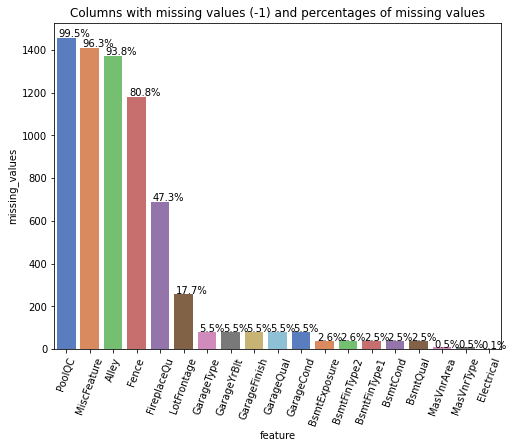

In [10]:
_ = show_missing_values(original_df)

### Explore object datatypes

In [11]:
unique_data_types(original_df)

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [12]:
for feature in columns_by_type(original_df, np.dtype('O')):
    unique_vals = original_df[feature].unique()
    print(f'{feature: <14} {len(unique_vals): <2} - {unique_vals}')

MSZoning       5  - ['RL' 'RM' 'C (all)' 'FV' 'RH']
Street         2  - ['Pave' 'Grvl']
Alley          3  - [nan 'Grvl' 'Pave']
LotShape       4  - ['Reg' 'IR1' 'IR2' 'IR3']
LandContour    4  - ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities      2  - ['AllPub' 'NoSeWa']
LotConfig      5  - ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope      3  - ['Gtl' 'Mod' 'Sev']
Neighborhood   25 - ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1     9  - ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2     8  - ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType       5  - ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle     8  - ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle      6  - ['Gable' 'Hip' 'Gambrel' 'M

## 2) Feature transformation

- convert them to the right types boolean, categorical etc.

### Split dataframe into features and target variable

In [13]:
original_y = original_df['SalePrice'].copy()
original_x = original_df.drop('SalePrice', axis=1).copy()

### Create Data object with data splitted to the train and test set 

In [14]:
train_x, test_x, train_y, test_y = train_test_split(original_x, original_y, test_size=0.20, random_state=SEED)

original = Data(name='original', train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y)

### Convert object features to ordinal, nominal, boolean etc.

- Because of the linear regression all the nominal features are one-hot encoded. (Not saying that which different regressor it would not be the same).

In [15]:
clean = original.copy(name='clean')
display(clean)

nominal_features = []
drop_features = []

# 'MSZoning':     Nominal
nominal_features.append('MSZoning')

# 'Street':       Boolean - street Paved or Gravel {'Pave', 'Grvl'}
clean.train_x['street_paved'] = (clean.train_x['Street'] == 'Pave')
clean.test_x['street_paved'] = (clean.test_x['Street'] == 'Pave')
drop_features.append('Street')

# 'Alley':        Boolean - alley Paved, Gravel (or NA-No Access not in data) {'Pave', 'Grvl', 'NA', nan}
clean.train_x['alley_paved'] = (clean.train_x['Alley'] == 'Pave')
clean.test_x['alley_paved'] = (clean.test_x['Alley'] == 'Pave')
drop_features.append('Alley')

# 'LotShape':     Ordinal - ['Reg' 'IR1' 'IR2' 'IR3']
clean.convert_feature_to_ordinal('LotShape', ['Reg', 'IR1', 'IR2', 'IR3'])

# 'LandContour':  Nominal - {Lvl-Flat/Level, Bnk-Banked, HLS-Hillside, Low-Depression}
nominal_features.append('LandContour') # (Could be ordinal but I am not sure about Low-Depression) 

# 'Utilities':    Ordinal - {'AllPub' (All), 'NoSewr' (El.+gas+water), 'NoSeWa' (El.+gas), 'ELO' (El.)}
clean.convert_feature_to_ordinal('Utilities', ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'])

# 'LotConfig':    Nominal - {'Inside', 'Corner', 'CulDSac' 'FR2', 'FR3'}
nominal_features.append('LotConfig')

# 'LandSlope':    Ordinal - {'Gtl' (Gentle), 'Mod' (Moderate), 'Sev' (Severe)}
clean.convert_feature_to_ordinal('LandSlope', ['Gtl', 'Mod', 'Sev'])

# 'Neighborhood': Nominal - Physical locations within Ames city limits
nominal_features.append('Neighborhood')

# 'Condition1':   Nominal - Proximity to various conditions
nominal_features.append('Condition1')

# 'Condition2':   Nominal - Proximity to various conditions (if more than one is present)
nominal_features.append('Condition2')

# 'BldgType':     Nominal - {1Fam, '2FmCon', 'Duplx', 'TwnhsE', 'TwnhsI'}
nominal_features.append('BldgType')
'''
f = 'HouseStyle'    #
f = 'RoofStyle'     #
f = 'RoofMatl'      #
f = 'Exterior1st'   #
f = 'Exterior2nd'   #
f = 'MasVnrType'    #
f = 'ExterQual'     #
f = 'ExterCond'     #
f = 'Foundation'    #
f = 'BsmtQual'      #
f = 'BsmtCond'      #
f = 'BsmtExposure'  #
f = 'BsmtFinType1'  #
f = 'BsmtFinType2'  #
f = 'Heating'       #
f = 'HeatingQC'     #
f = 'CentralAir'    #
f = 'Electrical'    #
f = 'KitchenQual'   #
f = 'Functional'    #
f = 'FireplaceQu'   #
f = 'GarageType'    #
f = 'GarageFinish'  #
f = 'GarageQual'    #
f = 'GarageCond'    #
f = 'PavedDrive'    #
f = 'PoolQC'        #
f = 'Fence'         #
f = 'MiscFeature'   #
f = 'SaleType'      #
f = 'SaleCondition' #
'''

# Convert nominal features from object to category type
for feature in nominal_features:
    clean.convert_feature_to_nominal(feature)
    
# One-hot encoding of the nominal features
clean.encode_features_one_hot(nominal_features)

# Drop features that were transformed into another ones
clean.drop_features(drop_features)

# Check ordinal features not for enumarated values 
show_missing_values(clean.train_x, missing_code=-1)

print('\n', f'Data after basic cleansing: {clean}')

<Data: name=clean, train_x.shape=(1168, 80), train_y.shape=(1168,) test_x.shape=(292, 80), test_y.shape=(292,)>

There are no missing values.

 Data after basic cleansing: <Data: name=clean, train_x.shape=(1168, 134), train_y.shape=(1168,) test_x.shape=(292, 134), test_y.shape=(292,)>


### Show unique feature types

In [16]:
unique_data_types(clean.train_x)

array([dtype('int64'), dtype('float64'), dtype('int8'), dtype('O'),
       dtype('bool')], dtype=object)

### Create temporary dataframe before the cleansing is not done

- Drop all unsanitized features (of object type, or with missing values)

In [17]:
drop_features = clean.train_x.columns[(clean.train_x.dtypes == np.dtype('O')) | (clean.train_x.isna().sum() != 0)]

temporary = clean.copy(suffix='tmp')
temporary.drop_features(drop_features)

In [18]:
temporary

<Data: name=clean_tmp, train_x.shape=(1168, 100), train_y.shape=(1168,) test_x.shape=(292, 100), test_y.shape=(292,)>

### Data Transformation 

In [19]:
transformers = [
    ('MinMaxScaler', MinMaxScaler()),
    ('PowerTransformer', PowerTransformer()),
    ('QuantileTransformer', QuantileTransformer()),
    ('RobustScaler', RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))), #unit_variance=True
    ('StandardScaler', StandardScaler()),
]

In [20]:
transformed_data = []

for name, transformer in transformers:
    data = temporary.copy(name=name)
    data.transform(transformer)
    transformed_data.append(data)

/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


### Check missing values for linear regression

In [23]:
temporary.train_x.isna().sum().sum()

0

### Train and evaluate transformed data

In [24]:
train_and_evaluate([temporary, *transformed_data])


 -------------------------------- Create models -------------------------------- 


 --------------------------------- Train models -------------------------------- 


[linear_regression] clean_tmp

[linear_regression] MinMaxScaler

[linear_regression] PowerTransformer

[linear_regression] QuantileTransformer

[linear_regression] RobustScaler

[linear_regression] StandardScaler

 -------------------- Transform negative predictions to zero ------------------- 

[linear_regression] clean_tmp        Number of negative predictions: 3
[linear_regression] MinMaxScaler     Number of negative predictions: 291
[linear_regression] PowerTransformer Number of negative predictions: 292
[linear_regression] QuantileTransformer Number of negative predictions: 0
[linear_regression] RobustScaler     Number of negative predictions: 3
[linear_regression] StandardScaler   Number of negative predictions: 291

 ------------------------------- Evaluate models ------------------------------- 


 -------------

## 3) Features subset

In [25]:
subset = temporary.copy(name='subset')

### Feature importance

In [28]:
features_nums = [
    ('rows_one_third', int(np.ceil(subset.train_x.shape[0]/3))),
    ('rows_sqrt', int(np.ceil(np.sqrt(subset.train_x.shape[0])))),
    ('rows_cbrt', int(np.ceil(np.cbrt(subset.train_x.shape[0])))),
    ('rows_log2', int(np.ceil(np.log2(subset.train_x.shape[0])))),
]

features_nums = [(name, num) for name, num in features_nums if num <= len(temporary.train_x.columns)]

subset_data = []

for name, features_num in features_nums:
    data = subset.copy(suffix=name)
    regressor = LinearRegression()
    selector = RFE(regressor, n_features_to_select=features_num, step=1)
    selector = selector.fit(subset.train_x, subset.train_x)
    
    drop_features = subset.train_x.columns[~ selector.support_]
    data.drop_features(drop_features)
    
    subset_data.append(data)

In [30]:
train_and_evaluate([temporary, *subset_data])


 -------------------------------- Create models -------------------------------- 


 --------------------------------- Train models -------------------------------- 


[linear_regression] clean_tmp

[linear_regression] subset_rows_sqrt

[linear_regression] subset_rows_cbrt

[linear_regression] subset_rows_log2

 -------------------- Transform negative predictions to zero ------------------- 

[linear_regression] clean_tmp        Number of negative predictions: 3
[linear_regression] subset_rows_sqrt Number of negative predictions: 1
[linear_regression] subset_rows_cbrt Number of negative predictions: 0
[linear_regression] subset_rows_log2 Number of negative predictions: 0

 ------------------------------- Evaluate models ------------------------------- 


 -------------------------- Root-Mean-Square Log Error ------------------------- 

[linear_regression] clean_tmp        Root-Mean-Square Log Error: 1.389
[linear_regression] subset_rows_sqrt Root-Mean-Square Log Error: 0.67491
[linear

## 4) Principal Component Analysis

In [32]:
pca = temporary.copy(name='pca')

In [34]:
components_nums = [
    ('rows_one_third', int(np.ceil(pca.train_x.shape[0]/3))),
    ('rows_sqrt', int(np.ceil(np.sqrt(pca.train_x.shape[0])))),
    ('rows_cbrt', int(np.ceil(np.cbrt(pca.train_x.shape[0])))),
    ('rows_log2', int(np.ceil(np.log2(pca.train_x.shape[0])))),
]

components_nums = [(name, num) for name, num in components_nums if num <= len(temporary.train_x.columns)]
print(components_nums)    

data_pca = []

for name, components_num in components_nums:
    data = temporary.copy(suffix=name)
#     cn = components_num if len(data.train_x.columns) >= components_num else 
    data.reduce(PCA(n_components=components_num, svd_solver='full'))
    data_pca.append(data)

[('rows_sqrt', 35), ('rows_cbrt', 11), ('rows_log2', 11)]


In [35]:
train_and_evaluate([temporary, *data_pca])


 -------------------------------- Create models -------------------------------- 


 --------------------------------- Train models -------------------------------- 


[linear_regression] clean_tmp

[linear_regression] clean_tmp_rows_sqrt

[linear_regression] clean_tmp_rows_cbrt

[linear_regression] clean_tmp_rows_log2

 -------------------- Transform negative predictions to zero ------------------- 

[linear_regression] clean_tmp        Number of negative predictions: 3
[linear_regression] clean_tmp_rows_sqrt Number of negative predictions: 0
[linear_regression] clean_tmp_rows_cbrt Number of negative predictions: 0
[linear_regression] clean_tmp_rows_log2 Number of negative predictions: 0

 ------------------------------- Evaluate models ------------------------------- 


 -------------------------- Root-Mean-Square Log Error ------------------------- 

[linear_regression] clean_tmp        Root-Mean-Square Log Error: 1.389
[linear_regression] clean_tmp_rows_sqrt Root-Mean-Square Log E

## 5) Results comparison 

Both selection and pca helps a lot, PCA was in this case better choice.